In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from IPython.display import FileLink 

# ======================================================
# 1. Configuration & Hyperparameters
# ======================================================
# Paths
TRAIN_DIR = '/kaggle/input/animal-faces/afhq/train' 
VAL_DIR = '/kaggle/input/animal-faces/afhq/val' 

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32           
EPOCHS_PHASE_1 = 12       # ✅ Fixed to 12 Epochs as requested
FINE_TUNE_EPOCHS = 5      # Extra epochs for fine-tuning
LR_PHASE_2 = 0.0001       # Low Learning Rate (1e-4)

# Output Files
MODEL_NAME = 'animal_faces_ultimate.keras'
CLASS_NAMES_FILE = 'class_names.txt'

print(f"🚀 Project Configured.")
print(f"⚙️ Phase 1 Epochs: {EPOCHS_PHASE_1}")
print(f"⚙️ Fine-Tuning Epochs: {FINE_TUNE_EPOCHS}")

2025-11-24 20:32:25.766274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764016345.961572      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764016346.015363      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🚀 Project Configured.
⚙️ Phase 1 Epochs: 12
⚙️ Fine-Tuning Epochs: 5


In [2]:
# ======================================================
# 2. Data Loading & Preprocessing
# ======================================================
print("📦 Loading Datasets...")

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"🏷️  Detected Classes: {class_names}")

with open(CLASS_NAMES_FILE, "w") as f:
    f.write("\n".join(class_names))

def adapt_label(image, label):
    return image, tf.one_hot(label, num_classes)

train_ds = train_ds_raw.map(adapt_label)
val_ds = val_ds_raw.map(adapt_label)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Data Pipeline Ready.")

📦 Loading Datasets...
Found 14630 files belonging to 3 classes.


I0000 00:00:1764016372.194525      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1500 files belonging to 3 classes.
🏷️  Detected Classes: ['cat', 'dog', 'wild']
✅ Data Pipeline Ready.


In [3]:
# ======================================================
# 3. Model Architecture (MobileNetV2)
# ======================================================
print("\n🧠 Building Model...")

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),    
    layers.RandomBrightness(0.2),  
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet' 
)
base_model.trainable = False 

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, 
                 activation='softmax',
                 kernel_regularizer=regularizers.l2(0.001)) 
])

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


🧠 Building Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# ======================================================
# 4. Phase 1: Initial Training
# ======================================================
print(f"\n🚀 Starting Phase 1 Training ({EPOCHS_PHASE_1} Epochs)...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE_1
)

# --- Calculate Phase 1 Averages (Last 3 Epochs) ---
last_n = 3
p1_acc = np.mean(history.history['val_accuracy'][-last_n:]) * 100
p1_loss = np.mean(history.history['val_loss'][-last_n:])

print("\n📊 Phase 1 Report (Before Fine-Tuning):")
print("-" * 40)
print(f"✅ Avg Validation Accuracy: {p1_acc:.2f}%")
print(f"📉 Avg Validation Loss:     {p1_loss:.4f}")
print("-" * 40)


🚀 Starting Phase 1 Training (12 Epochs)...
Epoch 1/12


I0000 00:00:1764016420.042437     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


458/458 ━━━━━━━━━━━━━━━━━━━━ 65s 49ms/step - accuracy: 0.9358 - loss: 0.4460 - val_accuracy: 0.9973 - val_loss: 0.3171
Epoch 2/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9944 - loss: 0.3268 - val_accuracy: 0.9973 - val_loss: 0.3099
Epoch 3/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9957 - loss: 0.3202 - val_accuracy: 0.9967 - val_loss: 0.3091
Epoch 4/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9958 - loss: 0.3173 - val_accuracy: 0.9967 - val_loss: 0.3138
Epoch 5/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9956 - loss: 0.3177 - val_accuracy: 0.9973 - val_loss: 0.3105
Epoch 6/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9961 - loss: 0.3181 - val_accuracy: 0.9967 - val_loss: 0.3090
Epoch 7/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9960 - loss: 0.3184 - val_accuracy: 0.9967 - val_loss: 0.3084
Epoch 8/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9957 - loss: 0.3181 - val_accurac


📊 Generating Zoomed-in Plots...


/tmp/ipykernel_48/441368306.py:68: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


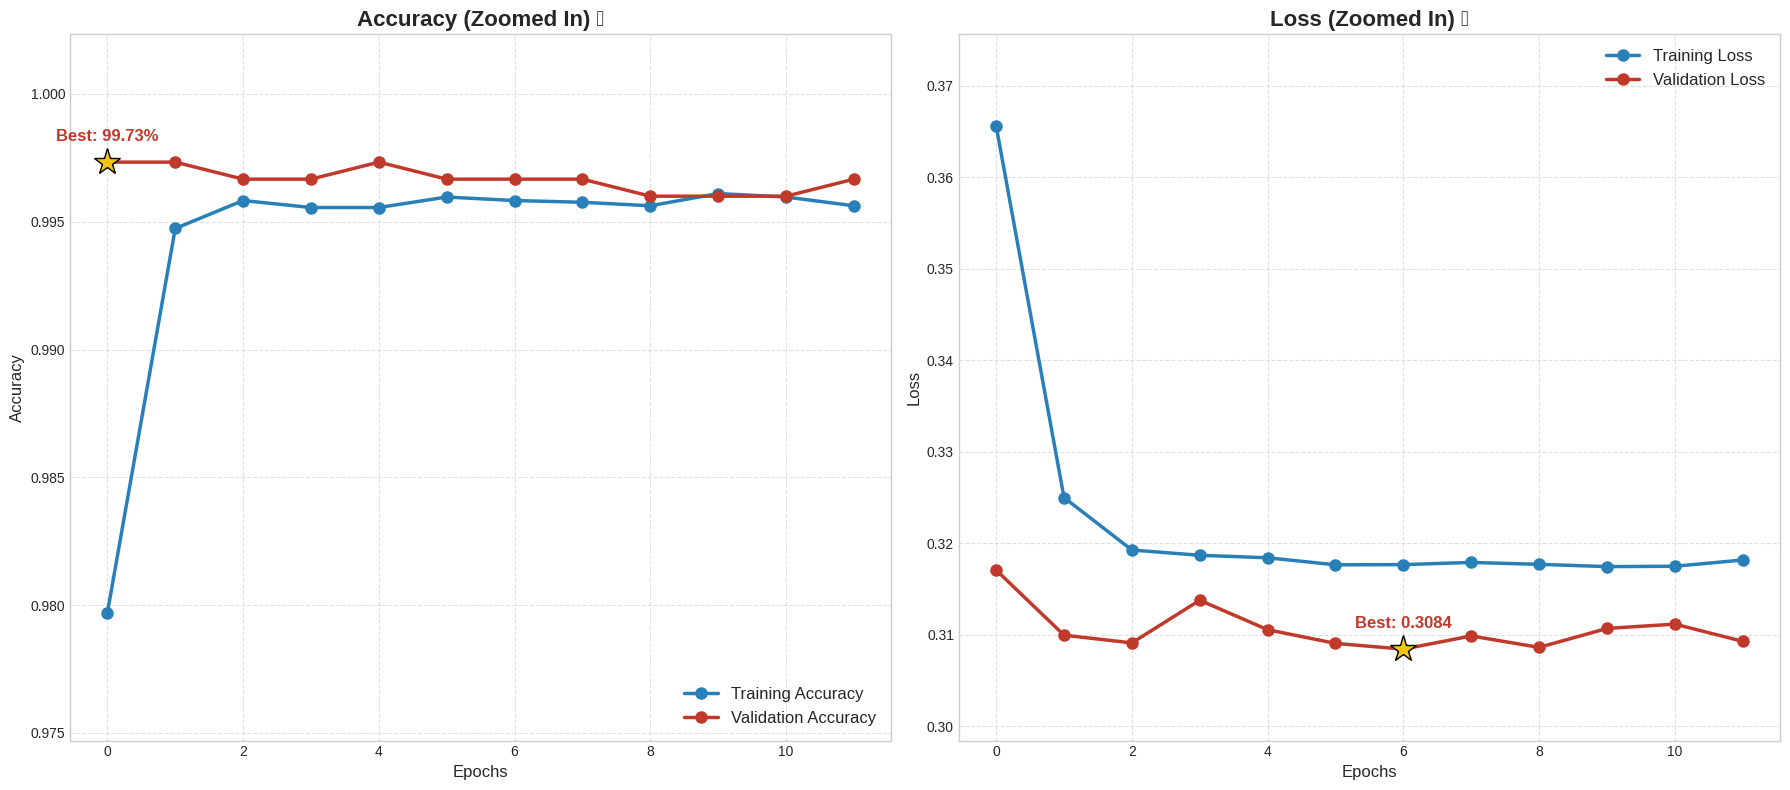


📋 Final Report (Average of last 3 epochs):
----------------------------------------
✅ Final Validation Accuracy: 99.62%
📉 Final Validation Loss:     0.3104
----------------------------------------


In [5]:
# ======================================================
# 5. Results & Visualization د
# ======================================================
import matplotlib.pyplot as plt
import numpy as np

# Apply clean style
plt.style.use('seaborn-v0_8-whitegrid') 

print("\n📊 Generating Zoomed-in Plots...")

# Extract data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Find Best Epochs
best_epoch_acc = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch_acc]
best_epoch_loss = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch_loss]

# Create Figure
plt.figure(figsize=(18, 8)) # Increased height for better view

# --- Plot 1: Accuracy (Zoomed) ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', label='Training Accuracy', color='#2980b9', linewidth=2.5, markersize=8)
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', color='#c0392b', linewidth=2.5, markersize=8)

# Highlight Best Point
plt.plot(best_epoch_acc, best_val_acc, '*', color='#f1c40f', markersize=20, markeredgecolor='black')
plt.annotate(f'Best: {best_val_acc:.2%}', (best_epoch_acc, best_val_acc), xytext=(0, 15), textcoords='offset points', ha='center', fontsize=12, fontweight='bold', color='#c0392b')

# 🔍 ZOOM MAGIC: Calculate limits dynamically
min_y = min(min(acc), min(val_acc)) - 0.005 # Leave small padding below
max_y = max(max(acc), max(val_acc)) + 0.005 # Leave small padding above
plt.ylim(min_y, max_y) # Force Zoom

plt.title('Accuracy (Zoomed In) 🔍', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Loss (Zoomed) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label='Training Loss', color='#2980b9', linewidth=2.5, markersize=8)
plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='#c0392b', linewidth=2.5, markersize=8)

# Highlight Best Point
plt.plot(best_epoch_loss, best_val_loss, '*', color='#f1c40f', markersize=20, markeredgecolor='black')
plt.annotate(f'Best: {best_val_loss:.4f}', (best_epoch_loss, best_val_loss), xytext=(0, 15), textcoords='offset points', ha='center', fontsize=12, fontweight='bold', color='#c0392b')

# 🔍 ZOOM MAGIC: Calculate limits dynamically
min_y_loss = min(min(loss), min(val_loss)) - 0.01
max_y_loss = max(max(loss), max(val_loss)) + 0.01
plt.ylim(min_y_loss, max_y_loss) # Force Zoom

plt.title('Loss (Zoomed In) 🔍', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Final Report
last_n = 3
avg_acc = np.mean(val_acc[-last_n:]) * 100
avg_loss = np.mean(val_loss[-last_n:])

print("\n📋 Final Report (Average of last 3 epochs):")
print("-" * 40)
print(f"✅ Final Validation Accuracy: {avg_acc:.2f}%")
print(f"📉 Final Validation Loss:     {avg_loss:.4f}")
print("-" * 40)

In [6]:
# ======================================================
# 6. Zip & Manual Download Instructions
# ======================================================
import shutil
import os
from IPython.display import FileLink

print("💾 Saving and Zipping Files...")

# 1. Save the model & names
model.save(MODEL_NAME)

# 2. Create a Zip file (Easier to download)
zip_filename = 'animal_faces_project.zip'
files_to_zip = [MODEL_NAME, CLASS_NAMES_FILE]

# Check if files exist before zipping
if os.path.exists(MODEL_NAME) and os.path.exists(CLASS_NAMES_FILE):
    # Create Zip
    with  tf.device('/CPU:0'): # Move to CPU to avoid any GPU lock issues
        with  open(zip_filename, 'wb') as f_out:
            pass # Create empty file first
            
    # Use system command to zip (more reliable in Kaggle)
    os.system(f"zip {zip_filename} {MODEL_NAME} {CLASS_NAMES_FILE}")
    
    print(f"\n✅ SUCCESS: Files zipped into '{zip_filename}'")
    print("👇 Try clicking this link first:")
    display(FileLink(zip_filename))
    
    print("\n" + "="*50)
    print("🛑 IF THE LINK DOES NOT WORK, FOLLOW THESE STEPS:")
    print("1. Look at the RIGHT SIDEBAR of this page.")
    print("2. Click on the 'Output' folder (under the 'Input' folder).")
    print("3. You will see 'animal_faces_project.zip'.")
    print("4. Click the three dots (...) next to it and select 'Download'.")
    print("="*50)
    
else:
    print("❌ ERROR: Source files not found. Training might have failed.")

💾 Saving and Zipping Files...
	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (animal_faces_project.zip)

✅ SUCCESS: Files zipped into 'animal_faces_project.zip'
👇 Try clicking this link first:


/kaggle/working/animal_faces_project.zip


🛑 IF THE LINK DOES NOT WORK, FOLLOW THESE STEPS:
1. Look at the RIGHT SIDEBAR of this page.
2. Click on the 'Output' folder (under the 'Input' folder).
3. You will see 'animal_faces_project.zip'.
4. Click the three dots (...) next to it and select 'Download'.
